# Inroduction


This sample notebook demonstrates how to process live data streams using Pathway. The dataset used here is a subset of the one provided — specifically, it includes data for only a single parking spot. You are expected to implement your model across all parking spots.

Please note that the pricing model used in this notebook is a simple baseline. You are expected to design and implement a more advanced and effective model.


In [164]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

In [165]:
!pip install -U pathway

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# Step 1: Importing and Preprocessing the Data

In [167]:
#df = pd.read_csv('/content/Modified - modified (1).csv')  "C:\Users\lasya\Downloads\dataset.csv"
#df

# You can find the sample dataset here: https://drive.google.com/file/d/1D479FLjp9aO3Mg8g6Lpj9oRViWacurA6/view?usp=sharing

In [168]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (2).csv


In [169]:
df= pd.read_csv ('dataset.csv')
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [170]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00


In [171]:
#df.to_csv('dataset_clean.csv', index=False)


df_cleaned = df[['Timestamp', 'Occupancy', 'Capacity', 'QueueLength',
                 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType']]

df_cleaned.to_csv("final_input.csv", index=False)

print(df_cleaned.head())
print(df_cleaned.columns)

            Timestamp  Occupancy  Capacity  QueueLength  \
0 2016-10-04 07:59:00         61       577            1   
1 2016-10-04 07:59:00        237      1200            2   
2 2016-10-04 07:59:00        264       687            2   
3 2016-10-04 07:59:00        249       485            2   
4 2016-10-04 07:59:00        614      1920            2   

  TrafficConditionNearby  IsSpecialDay VehicleType  
0                    low             0         car  
1                    low             0        bike  
2                    low             0         car  
3                    low             0         car  
4                    low             0       cycle  
Index(['Timestamp', 'Occupancy', 'Capacity', 'QueueLength',
       'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType'],
      dtype='object')


In [172]:
from google.colab import files
files.download("final_input.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [173]:
df.VehicleType.unique()
df.TrafficConditionNearby.unique()

array(['low', 'average', 'high'], dtype=object)

In [174]:
# Set base price and alpha
base_price = 10
alpha = 4  # checked manually for the best values

# Create a new column to store model 1 price
df['price_model1'] = np.nan

# Get unique parking lot IDs
lot_ids = df['ID'].unique()

# Apply the price logic per lot
for lot in lot_ids:
    lot_mask = df['ID'] == lot
    lot_df = df[lot_mask]

    # Initial price
    prev_price = base_price
    prices = []

    for _, row in lot_df.iterrows():
        occ = row['Occupancy']
        cap = row['Capacity']
        occ_ratio = occ / cap if cap > 0 else 0  # avoid division by 0

        # Model 1 formula: price = prev_price + alpha * (occupancy/capacity)
        current_price = prev_price + alpha * occ_ratio
        prices.append(current_price)

        # Update for next step
        prev_price = current_price

    # Assign prices back into the main dataframe
    df.loc[lot_mask, 'price_model1'] = prices

In [175]:
# Vehicle weights
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'cycle': 0.2,
    'truck': 1.5
}
df['vehicle_weight'] = df['VehicleType'].map(vehicle_weights).fillna(1.0)

# Traffic weights: low = 1, average = 2, high = 3
traffic_weights = {
    'low': 1,
    'average': 2,
    'high': 3
}
df['traffic_level'] = df['TrafficConditionNearby'].map(traffic_weights).fillna(1)

In [176]:
# Set the weights for each feature
a = 0.4  # occupancy
b = 0.3  # queue
c = 0.2  # traffic (penalty)
d = 0.1  # special day
e = 0.3  # vehicle type

# Avoid division by zero
df['Capacity'] = df['Capacity'].replace(0, 1)

# Demand Score
df['demand_score'] = (
    a * (df['Occupancy'] / df['Capacity']) +
    b * df['QueueLength'] -
    c * df['traffic_level'] +
    d * df['IsSpecialDay'] +
    e * df['vehicle_weight']
)

In [177]:
# Normalize demand to [0, 1]
min_d = df['demand_score'].min()
max_d = df['demand_score'].max()

df['demand_normalized'] = (df['demand_score'] - min_d) / (max_d - min_d)

base_price = 10
lambda_ = 0.5  # strength of demand effect

df['price_model2'] = base_price * (1 + lambda_ * df['demand_normalized'])

# Clip price between $5 and $20
df['price_model2'] = df['price_model2'].clip(lower=5, upper=20)

In [178]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,price_model1,vehicle_weight,traffic_level,demand_score,demand_normalized,price_model2
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.422877,1.0,1,0.442288,0.103164,10.515820
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.790000,0.5,1,0.629000,0.142907,10.714536
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,11.537118,1.0,1,0.853712,0.190739,10.953694
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,12.053608,1.0,1,0.905361,0.201733,11.008663
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,11.279167,0.2,1,0.587917,0.134162,10.670811


In [179]:
print(df.columns)

Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime', 'Timestamp',
       'price_model1', 'vehicle_weight', 'traffic_level', 'demand_score',
       'demand_normalized', 'price_model2'],
      dtype='object')


In [180]:
df['SystemCodeNumber'].unique()

array(['BHMBCCMKT01', 'BHMNCPHST01', 'BHMMBMMBX01', 'BHMNCPNST01',
       'Shopping', 'BHMEURBRD01', 'Broad Street', 'Others-CCCPS8',
       'Others-CCCPS105a', 'Others-CCCPS119a', 'BHMBCCTHL01',
       'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98'],
      dtype=object)

In [181]:
lot_code = 'BHMBCCMKT01'

lot_df = df[df['SystemCodeNumber'] == lot_code].copy()


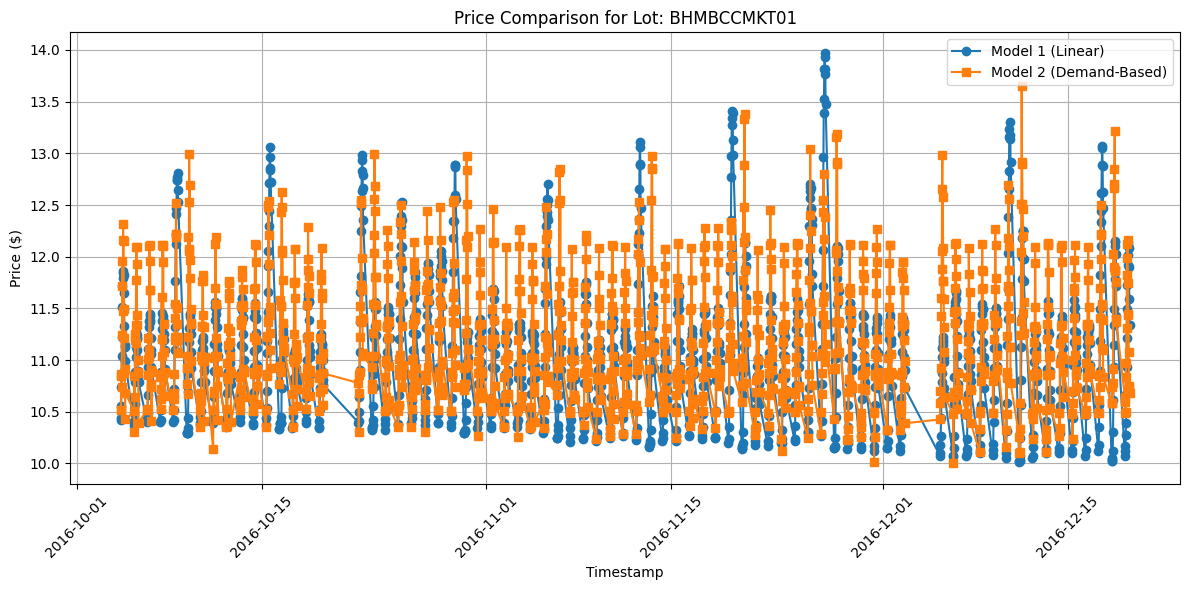

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(lot_df['Timestamp'], lot_df['price_model1'], label='Model 1 (Linear)', marker='o')
plt.plot(lot_df['Timestamp'], lot_df['price_model2'], label='Model 2 (Demand-Based)', marker='s')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Price Comparison for Lot: {lot_code}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Making a simple pricing function

In [183]:
import pathway as pw

In [184]:
import csv

with open("final_input.csv", "r") as f:
    reader = csv.DictReader(f)
    print(reader.fieldnames)

['Timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType']


In [185]:
import pathway as pw
from datetime import timedelta

@pw.udf
def map_vehicle_type(vtype: str) -> float:
    mapping = {'car': 1.0, 'bike': 0.5, 'truck': 1.5, 'cycle': 0.2}
    return mapping.get(vtype, 1.0)

@pw.udf
def map_traffic(level: str) -> int:
    mapping = {'low': 1, 'average': 2, 'high': 3}
    return mapping.get(level, 1)

In [186]:
@pw.udf
def clip_price(value: float, min_val: float = 5.0, max_val: float = 20.0) -> float:
    return max(min(value, max_val), min_val)

In [187]:
class ParkingSchema(pw.Schema):
    Timestamp: str
    Occupancy: int
    Capacity: int
    QueueLength: int
    TrafficConditionNearby: str
    IsSpecialDay: int
    VehicleType: str



In [188]:
from datetime import timedelta

# Read stream and attach parsed_time from internal timestamp
data = pw.demo.replay_csv(
    "final_input.csv",
    schema=ParkingSchema,
    input_rate=1000
)

# Format timestamp
fmt = "%Y-%m-%d %H:%M:%S"
data_with_time = data.with_columns(
    t=data.Timestamp.dt.strptime(fmt),
    day=data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)

In [189]:
from datetime import timedelta

reduced_window = data_with_time.windowby(
    pw.this.t,
    instance=pw.this.day,
    window=pw.temporal.tumbling(duration=timedelta(days=1)),
    behavior=pw.temporal.exactly_once_behavior()
).reduce(
    t = pw.this._pw_window_end,
    occupancy = pw.reducers.max(pw.this.Occupancy),
    capacity = pw.reducers.max(pw.this.Capacity),
    queue = pw.reducers.max(pw.this.QueueLength),
    traffic = pw.reducers.max(pw.this.TrafficConditionNearby),
    special_day = pw.reducers.max(pw.this.IsSpecialDay),
    vehicle = pw.reducers.max(pw.this.VehicleType),

)

In [190]:
final_output = reduced_window.with_columns(
    vehicle_weight = map_vehicle_type(pw.this.vehicle),

    demand = (
        0.4 * (pw.this.occupancy / pw.this.capacity) +
        0.3 * pw.this.queue -
        0.2 * map_traffic(pw.this.traffic) +
        0.1 * pw.this.special_day +
        0.3 * map_vehicle_type(pw.this.vehicle)
    ),

    demand_clamped = clip_price(
        0.4 * (pw.this.occupancy / pw.this.capacity) +
        0.3 * pw.this.queue -
        0.2 * map_traffic(pw.this.traffic) +
        0.1 * pw.this.special_day +
        0.3 * map_vehicle_type(pw.this.vehicle), 0, 1
    ),

    price_model1 = clip_price(10 + 4 * (pw.this.occupancy / pw.this.capacity)),

    price_model2 = clip_price(
        10 * (1 + 0.5 * clip_price(
            0.4 * (pw.this.occupancy / pw.this.capacity) +
            0.3 * pw.this.queue -
            0.2 * map_traffic(pw.this.traffic) +
            0.1 * pw.this.special_day +
            0.3 * map_vehicle_type(pw.this.vehicle), 0, 1
        ))
    )
)

In [191]:
print(data.schema)

id          | Timestamp | Occupancy | Capacity | QueueLength | TrafficConditionNearby | IsSpecialDay | VehicleType
ANY_POINTER | STR       | INT       | INT      | INT         | STR                    | INT          | STR        


# Step 3: Visualizing Daily Price Fluctuations with a Bokeh Plot

In [192]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Legend
output_notebook()

In [193]:
from pathway.io.python import write, ConnectorObserver

In [194]:
import os
if os.path.exists("output_prices.csv"):
    os.remove("output_prices.csv")

In [195]:
from pathway.internals import cast

pw.io.csv.write(
    final_output.select(
        t = pw.this.t,

        price_model1 = cast(float, pw.this.price_model1),
        price_model2 = cast(float, pw.this.price_model2)
    ),
    filename="output_prices.csv"
)

In [196]:
pw.run()

Output()

In [197]:
!head -n 15 output_prices.csv

"t","price_model1","price_model2","time","diff"
"2016-10-05T00:00:00.000000000","14.186196240020603","15.0","1752074348576","1"
"2016-10-06T00:00:00.000000000","13.309812001030132","15.0","1752074348958","1"
"2016-10-07T00:00:00.000000000","13.23152201905743","15.0","1752074349380","1"
"2016-10-08T00:00:00.000000000","12.75663147051249","15.0","1752074349776","1"
"2016-10-09T00:00:00.000000000","11.648210146793716","15.0","1752074350172","1"
"2016-10-10T00:00:00.000000000","11.077517383466391","15.0","1752074350604","1"
"2016-10-11T00:00:00.000000000","13.115117177440123","15.0","1752074351000","1"
"2016-10-12T00:00:00.000000000","13.304661344321401","15.0","1752074351398","1"
"2016-10-13T00:00:00.000000000","13.235642544424413","15.0","1752074351818","1"
"2016-10-14T00:00:00.000000000","13.319083183105846","15.0","1752074352214","1"
"2016-10-15T00:00:00.000000000","12.770023177955188","15.0","1752074352694","1"
"2016-10-16T00:00:00.000000000","11.554468194694824","15.0","1752074353102

In [198]:
'''import pandas as pd
df = pd.read_csv("output_prices.csv")
df.head()'''

'import pandas as pd\ndf = pd.read_csv("output_prices.csv")\ndf.head()'

In [199]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh.layouts import column

output_notebook()

In [200]:
df = pd.read_csv("output_prices.csv", on_bad_lines='skip')
# Let pandas infer the format for more flexibility
df['t'] = pd.to_datetime(df['t'], errors='coerce')
df = df.dropna(subset=['t']) # Drop rows where 't' could not be parsed
df = df.sort_values('t')  # sort by time (optional but cleaner)

In [209]:
# Final edited code
# Read stream directly without windowing or reducing
data = pw.demo.replay_csv(
    "final_input.csv",
    schema=ParkingSchema,
    input_rate=1000 # Adjust as needed
)

# Format timestamp (still needed for plotting later)
fmt = "%Y-%m-%d %H:%M:%S"
data_with_time = data.with_columns(
    t=data.Timestamp.dt.strptime(fmt)
)

# Apply the pricing logic directly to each row - chained with_columns
final_output = data_with_time.with_columns(
    # Define foundational columns
    vehicle_weight = map_vehicle_type(pw.this.VehicleType),
).with_columns(
    traffic_level = map_traffic(pw.this.TrafficConditionNearby)
).with_columns(
    capacity_safe = pw.if_else(pw.this.Capacity != 0, pw.this.Capacity, 1),
).with_columns(
    # Calculate raw demand, handling potential None values and division by zero
    raw_demand = (
        0.4 * pw.if_else(
            pw.this.capacity_safe == 0,
            0.0, # Default to 0 if capacity_safe is 0
            pw.if_else(pw.this.Occupancy.is_none(), 0.0, pw.this.Occupancy) / pw.if_else(pw.this.capacity_safe.is_none(), 1.0, pw.this.capacity_safe)
        ) +
        0.3 * pw.if_else(pw.this.QueueLength.is_none(), 0.0, pw.this.QueueLength) -
        0.2 * pw.if_else(pw.this.traffic_level.is_none(), 1.0, pw.this.traffic_level) +
        0.1 * pw.if_else(pw.this.IsSpecialDay.is_none(), 0.0, pw.this.IsSpecialDay) +
        0.3 * pw.if_else(pw.this.vehicle_weight.is_none(), 1.0, pw.this.vehicle_weight)
    )
).with_columns(
    # Clip demand to [0, 1] using pw.if_else
    demand_clipped_for_price2 = pw.if_else(
        pw.this.raw_demand < 0.0, 0.0,
        pw.if_else(pw.this.raw_demand > 1.0, 1.0, pw.this.raw_demand)
    )
).with_columns(
    # Model 1 raw price calculation, handling potential division by zero
    price_model1_raw = 10.0 + 4.0 * pw.if_else(
        pw.this.capacity_safe == 0,
        0.0, # Default to 0 if capacity_safe is 0
        pw.if_else(pw.this.Occupancy.is_none(), 0.0, pw.this.Occupancy) / pw.if_else(pw.this.capacity_safe.is_none(), 1.0, pw.this.capacity_safe)
    )
).with_columns(
    # Apply clipping to price_model1_raw using pw.if_else
    price_model1 = pw.if_else(
        pw.this.price_model1_raw < 5.0, 5.0,
        pw.if_else(pw.this.price_model1_raw > 20.0, 20.0, pw.this.price_model1_raw)
    )
).with_columns(
    # Model 2 raw price calculation using clipped demand
    price_model2_raw = 10.0 * (1.0 + 0.5 * pw.this.demand_clipped_for_price2)
).with_columns(
    # Apply clipping to price_model2_raw using pw.if_else
    price_model2 = pw.if_else(
        pw.this.price_model2_raw < 5.0, 5.0,
        pw.if_else(pw.this.price_model2_raw > 20.0, 20.0, pw.this.price_model2_raw)
    )
)


# Print the schema of the output table to verify columns
print(final_output.schema)

# Write the output to a CSV file
import os
if os.path.exists("output_prices_full.csv"):
    os.remove("output_prices_full.csv")

# Select columns for writing
pw.io.csv.write(
    final_output.select(
        Timestamp = pw.this.Timestamp, # Keep original timestamp if desired
        t = pw.this.t, # Or the parsed datetime object
        price_model1 = pw.this.price_model1,
        price_model2 = pw.this.price_model2
    ),
    filename="output_prices_full.csv"
)

# Run the Pathway pipeline
pw.run()

# Verify the output file
!head -n 15 output_prices_full.csv

# Read the output file into a pandas DataFrame to check the number of rows
output_notebook()
df_full = pd.read_csv("output_prices_full.csv", on_bad_lines='skip')
# Let pandas infer the format for more flexibility
df_full['t'] = pd.to_datetime(df_full['t'], errors='coerce')
df_full = df_full.dropna(subset=['t']) # Drop rows where 't' could not be parsed
df_full = df_full.sort_values('t')  # sort by time (optional but cleaner)

print(df_full.shape)
print(df_full.head())

id          | Timestamp | Occupancy | Capacity | QueueLength | TrafficConditionNearby | IsSpecialDay | VehicleType | t               | vehicle_weight | traffic_level | capacity_safe | raw_demand | demand_clipped_for_price2 | price_model1_raw | price_model1 | price_model2_raw | price_model2
ANY_POINTER | STR       | INT       | INT      | INT         | STR                    | INT          | STR         | DATE_TIME_NAIVE | FLOAT          | INT           | INT           | FLOAT      | FLOAT                     | FLOAT            | FLOAT        | FLOAT            | FLOAT       


Output()

"Timestamp","t","price_model1","price_model2","time","diff"
"2016-10-05 10:30:00","2016-10-05T10:30:00.000000000","12.666002986560478","15.0","1752074703646","1"
"2016-10-04 12:29:00","2016-10-04T12:29:00.000000000","13.125773195876288","15.0","1752074703646","1"
"2016-10-05 13:30:00","2016-10-05T13:30:00.000000000","12.536666666666667","15.0","1752074703646","1"
"2016-10-05 09:30:00","2016-10-05T09:30:00.000000000","12.370833333333334","15.0","1752074703646","1"
"2016-10-04 14:57:00","2016-10-04T14:57:00.000000000","10.754905458437388","15.0","1752074703646","1"
"2016-10-06 09:30:00","2016-10-06T09:30:00.000000000","12.33125","14.665625","1752074703646","1"
"2016-10-04 16:31:00","2016-10-04T16:31:00.000000000","12.74235807860262","14.87117903930131","1752074703646","1"
"2016-10-04 16:31:00","2016-10-04T16:31:00.000000000","11.883333333333333","12.241666666666667","1752074703646","1"
"2016-10-04 10:59:00","2016-10-04T10:59:00.000000000","11.518197573656845","15.0","1752074703646","1"
"

In [212]:
# Final code for bokeh graph
p = figure(
    title="Model 1 vs Model 2 Parking Prices Over Time (Full Data)",
    x_axis_type='datetime',
    width=900,
    height=400
)

p.line(df_full['t'], df_full['price_model1'], legend_label="Model 1 (Full)", line_width=2, color="blue")
p.line(df_full['t'], df_full['price_model2'], legend_label="Model 2 (Full)", line_width=2, color="orange")

# Tooltips for interactivity
hover = HoverTool(
    tooltips=[
        ("Time", "@x{%F %T}"),
        ("Model 1 Price", "@y{0.00}"),
        ("Model 2 Price", "@y{0.00}") # Adjust tooltip to show price for the line being hovered over
    ],
    formatters={'@x': 'datetime'},
    mode='vline'
)

p.add_tools(hover)

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price"
p.legend.location = "top_left"
p.title.text_font_size = "16pt"

show(p)
